In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

from IPython import display

import glob
import imageio
import tensorflow as tf
import time

In [5]:
dir_ = 'gz_grey_40/'
N = 58095

In [6]:
def load_image(d):
    
    img = Image.open(d)
    img.load()
    data = np.asarray(img, dtype='int32')
    
    return data

In [7]:
gzdata = np.zeros((N, 40, 40))

In [8]:
for i in range(N):
    d = dir_ + str(i+1) + '.jpg'
    gzdata[i] = load_image(d)

In [9]:
gzdata.max()
gzdata.shape

(58095, 40, 40)

# Data preprocessing

In [10]:
from sklearn.model_selection import train_test_split
mydata = gzdata

In [11]:
train_images, test_images = train_test_split(mydata, train_size=0.7, shuffle=True, random_state=42)

In [12]:
def preprocess_images(images):
    images = images.reshape((-1, 40, 40, 1)) / 255.
    return images

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

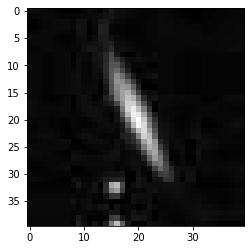

In [13]:
plt.imshow(test_images[0].reshape((40,40)), cmap='gray')
plt.show()

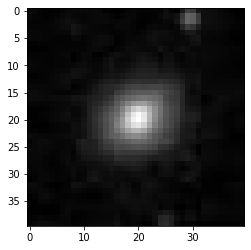

In [14]:
plt.imshow(train_images[0].reshape((40,40)), cmap='gray')
plt.show()

# Model building

In [15]:
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Reshape, Conv2D, Conv2DTranspose, Dropout, Input, Lambda
from tensorflow.keras.optimizers import SGD

In [16]:
def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon 

In [17]:
def build_vae_encoder(input_dim, output_dim):
        
    encoder_input = Input(shape=input_dim)
    x = Conv2D(filters=6, kernel_size=3, strides=(2,2), activation='relu', input_shape=input_dim, padding='same')(encoder_input)
    x = Conv2D(filters=12, kernel_size=3, strides=(2,2), activation='relu', padding='same')(x)
    x = Flatten()(x)
    x = Dense(output_dim, activation='relu', input_shape=[1200])(x)

    mu = Dense(output_dim)(x)
    log_sigma = Dense(output_dim)(x)
    
    encoder_output = Lambda(function=sampling)([mu, log_sigma])
    
    return encoder_input, encoder_output, mu, log_sigma, Model(encoder_input, encoder_output)

def build_vae_decoder(input_dim):
    
    decoder_out = Conv2DTranspose(filters=1, kernel_size=3, strides=(2,2), padding='same',
                    activation='sigmoid')
        
    decoder_input = Input(shape=input_dim)
    y = Dense(1200, activation='relu')(decoder_input)
    y = Reshape((10, 10, 12))(y)
    y = Conv2DTranspose(filters=6, kernel_size=3, strides=(2,2), padding='same',
                    activation='relu')(y)
    decoder_output = decoder_out(y)
    
    return decoder_input, decoder_output, Model(decoder_input, decoder_output)


In [18]:
vae_encoder_input, vae_encoder_output, mu, log_var, vae_encoder = build_vae_encoder((40,40,1), 100)
vae_decoder_input, vae_decoder_output, vae_decoder = build_vae_decoder(100)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [19]:
vae_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 40, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 20, 20, 6)    60          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 10, 10, 12)   660         conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1200)         0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [20]:
vae_decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1200)              121200    
_________________________________________________________________
reshape (Reshape)            (None, 10, 10, 12)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 20, 20, 6)         654       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 40, 40, 1)         55        
Total params: 121,909
Trainable params: 121,909
Non-trainable params: 0
_________________________________________________________________


In [21]:
vae_input = vae_encoder_input
vae_output = vae_decoder(vae_encoder_output)
vae_model = Model(vae_input, vae_output)

In [22]:
lr = 0.0005
loss_factor = 10000

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2])

def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return loss_factor * r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

vae_model.compile(optimizer=Adam(lr = lr), loss = total_loss, metrics = [r_loss, kl_loss])

In [23]:
vae_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 40, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 20, 20, 6)    60          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 10, 10, 12)   660         conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1200)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [24]:
# tf.compat.v1.disable_eager_execution()

In [25]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [26]:
vae_model.fit(train_images, train_images, epochs = 300, validation_data=(test_images, test_images), callbacks=[early_stop], batch_size=128)

Train on 40666 samples, validate on 17429 samples
Epoch 1/300
40666/40666 [==============================] - 9s 217us/sample - loss: 542.9410 - r_loss: 0.0484 - kl_loss: 59.4158 - val_loss: 74.7737 - val_r_loss: 0.0051 - val_kl_loss: 23.2808
Epoch 2/300
40666/40666 [==============================] - 9s 210us/sample - loss: 59.9537 - r_loss: 0.0043 - kl_loss: 16.7594 - val_loss: 52.1549 - val_r_loss: 0.0040 - val_kl_loss: 12.0919
Epoch 3/300
40666/40666 [==============================] - 8s 208us/sample - loss: 48.4896 - r_loss: 0.0036 - kl_loss: 12.4024 - val_loss: 45.5846 - val_r_loss: 0.0034 - val_kl_loss: 11.5480
Epoch 4/300
40666/40666 [==============================] - 8s 208us/sample - loss: 44.5662 - r_loss: 0.0033 - kl_loss: 11.2991 - val_loss: 43.7968 - val_r_loss: 0.0034 - val_kl_loss: 10.0531
Epoch 5/300
40666/40666 [==============================] - 9s 209us/sample - loss: 43.0168 - r_loss: 0.0032 - kl_loss: 10.7419 - val_loss: 41.8792 - val_r_loss: 0.0031 - val_kl_loss: 10

# Evaluating model

In [27]:
losses = pd.DataFrame(vae_model.history.history)
losses.columns

Index(['loss', 'r_loss', 'kl_loss', 'val_loss', 'val_r_loss', 'val_kl_loss'], dtype='object')

(0.0, 100.0)

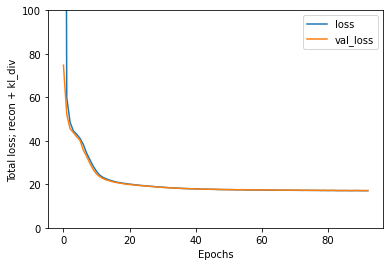

In [28]:
losses[['loss','val_loss']].plot()
# plt.yscale('log')
plt.ylabel('Total loss; recon + kl_div')
plt.xlabel('Epochs')
plt.ylim(0,100)

## Reconstruction metrics

In [29]:
vae_model.evaluate(test_images, test_images), vae_model.metrics_names

17429/17429 [==============================] - 2s 93us/sample - loss: 17.1112 - r_loss: 0.0012 - kl_loss: 5.1899


([17.11119023635552, 0.0011921267, 5.1899295], ['loss', 'r_loss', 'kl_loss'])

In [30]:
passed_images = vae_model.predict(test_images)

In [31]:
np.shape(passed_images)

(17429, 40, 40, 1)

In [32]:
passed_images = passed_images.reshape((-1, 40, 40))

In [33]:
X_test_r = test_images.reshape((-1, 40, 40))

In [34]:
passed_images.shape, X_test_r.shape

((17429, 40, 40), (17429, 40, 40))

# Plotting random images & comparing with true test images

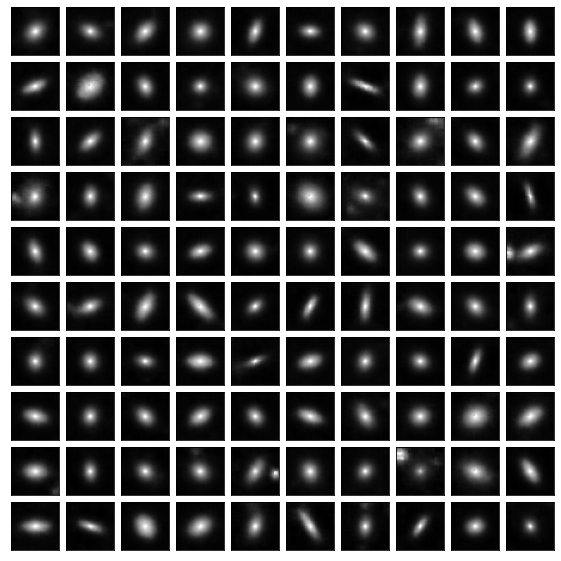

In [35]:
from random import randint

x = [randint(0, np.shape(passed_images)[0]) for p in range(0, 100)]

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(10, 10),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, passed_images[x]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('100randomgalaxy_variational_ae.jpg')
plt.show()

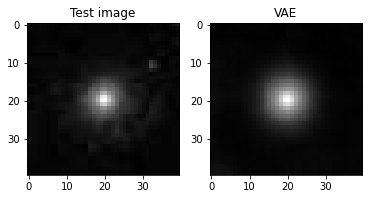

In [36]:
import random
n = random.randint(0, 17429)

f = plt.figure()
f.add_subplot(1,2, 2)
plt.imshow(passed_images[n], cmap='gray')
plt.title('VAE')

f.add_subplot(1,2, 1)
plt.imshow(X_test_r[n], cmap='gray')
plt.title('Test image')

plt.show(block=True)

## Reconstruction metrics

In [37]:
def fnmse(yHat, y):
    return np.mean((yHat-y)**2)

def bCrossEntropy(yHat, y):
    return -np.mean(y*np.log(yHat) + (1-y)*np.log(1-yHat))

def cosinedist(yHat, y):
    
    u = yHat.flatten()
    v = y.flatten() 
    normu = np.sqrt(np.sum(u**2))
    normv = np.sqrt(np.sum(v**2)) 
    cosine_dist = np.dot(u, v) / (normu*normv)
    
    return 1 - cosine_dist

In [38]:
mse, bce, cd = 0, 0, 0
n_test = np.shape(X_test_r)[0]

for i in range(n_test):
    
    yHat, y = passed_images[i], X_test_r[i]
    
    mse += fnmse(yHat, y)
    bce += bCrossEntropy(yHat, y)
    cd += cosinedist(yHat, y)
    
print("Mean square error", mse/n_test)
print("Binary Crossentropy", bce/n_test)
print("Cosine distance", cd/n_test)

Mean square error 0.0011954173701934413
Binary Crossentropy 0.21127904555419935
Cosine distance 0.039462921054961686


# UMAP embedding in 2d

In [39]:
latent_space = vae_encoder.predict(test_images)

In [40]:
print(np.shape(latent_space))

(17429, 100)


In [ ]:
# !pip install umap-learn

import umap

# create the embedding of the latent space
embedding = umap.UMAP(n_neighbors=100, min_dist=0.5).fit_transform(latent_space)
print(np.shape(embedding))

# plot the embedding
plt.scatter(embedding[:,0], embedding[:,1], alpha=0.1)
plt.title('Variational autoencoder; latent dim 100; lf recon + kl_div')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')